In [6]:
import itertools
from collections import defaultdict
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
test_path = '/content/drive/My Drive/circuits/c17.test'

In [9]:
# ------------------ Reproducibility ------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------ Expand Don't Care ------------------
def expand_dont_care(pattern):
    chars = [(c if c in '01' else ['0', '1']) for c in pattern]
    chars = [(c if isinstance(c, list) else [c]) for c in chars]
    return [''.join(bits) for bits in itertools.product(*chars)]

# ------------------ Parse .test File ------------------
def parse_isc_file(filepath):
    combo_to_faults = defaultdict(set)
    fault_to_combos = defaultdict(list)
    current_fault = None

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or line.startswith("*"):
                continue
            if '/' in line:
                parts = line.split("/")
                fault = parts[0].strip().replace("->", "_") + "/" + parts[1].strip()
                current_fault = fault
            elif ':' in line and current_fault:
                parts = line.split(":")[1].strip().split()
                input_pattern = parts[0]
                output_pattern = parts[1] if len(parts) > 1 else ""
                input_expanded = expand_dont_care(input_pattern)
                output_expanded = expand_dont_care(output_pattern)
                for xi in input_expanded:
                    for yo in output_expanded:
                        combined = xi + yo
                        combo_to_faults[combined].add(current_fault)
                        fault_to_combos[current_fault].append(combined)
    return combo_to_faults, fault_to_combos

# ------------------ Dataset Builder ------------------
def build_multilabel_dataset(combo_to_faults):
    all_faults = sorted({f for faults in combo_to_faults.values() for f in faults})
    fault_index = {fault: idx for idx, fault in enumerate(all_faults)}
    dataset = []
    for combo, faults in combo_to_faults.items():
        label_vector = [0] * len(all_faults)
        for fault in faults:
            label_vector[fault_index[fault]] = 1
        features = [int(bit) for bit in combo]
        dataset.append((features, label_vector))
    return dataset, fault_index

In [10]:
# ------------------ PyTorch Dataset ------------------
class FaultDataset(Dataset):
    def __init__(self, data):
        self.samples = data
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        features, labels = self.samples[idx]
        return (
            torch.tensor(features, dtype=torch.float32).unsqueeze(1),  # shape: [seq_len, 1]
            torch.tensor(labels, dtype=torch.float32)
        )

In [11]:
# ------------------ LSTM Model ------------------
class FaultLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FaultLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # [num_layers, batch, hidden_size]
        out = self.fc(hn[-1])  # use last hidden state
        return torch.sigmoid(out)

In [12]:
# ------------------ Load Data ------------------
combo_to_faults, fault_to_combos = parse_isc_file(test_path)
dataset, fault_index = build_multilabel_dataset(combo_to_faults)

train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=SEED)
train_dataset = FaultDataset(train_data)
val_dataset = FaultDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# ------------------ Model Setup ------------------
input_size = 1
hidden_size = 128
output_size = len(fault_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaultLSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# ------------------ Training Loop ------------------
train_losses, val_losses, val_f1s, val_accuracies = [], [], [], []

for epoch in range(50):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    y_true, y_pred = [], []
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            val_loss += criterion(out, y).item()
            y_true.append(y.cpu().numpy())
            y_pred.append((out.cpu().numpy() > 0.5).astype(int))

    val_losses.append(val_loss / len(val_loader))
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    acc = (y_true == y_pred).sum() / y_true.size
    val_f1s.append(f1)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Val F1: {f1:.4f} | Val Acc: {acc:.4f}")

# ------------------ Final Evaluation ------------------
stuck_at_0_indices = [idx for fault, idx in fault_index.items() if fault.endswith('/0')]
stuck_at_1_indices = [idx for fault, idx in fault_index.items() if fault.endswith('/1')]

def type_accuracy(y_true, y_pred, indices, fault_type):
    y_true_type = y_true[:, indices]
    y_pred_type = y_pred[:, indices]
    correct = (y_true_type == y_pred_type).sum()
    total = y_true_type.size
    acc = correct / total if total > 0 else 0
    print(f"{fault_type} Accuracy: {acc:.4f} ({correct}/{total})")

Epoch  1 | Train Loss: 0.6874 | Val Loss: 0.6789 | Val F1: 0.0773 | Val Acc: 0.7245
Epoch  2 | Train Loss: 0.6737 | Val Loss: 0.6613 | Val F1: 0.0940 | Val Acc: 0.8090
Epoch  3 | Train Loss: 0.6496 | Val Loss: 0.6286 | Val F1: 0.0632 | Val Acc: 0.8472
Epoch  4 | Train Loss: 0.6042 | Val Loss: 0.5596 | Val F1: 0.0632 | Val Acc: 0.8472
Epoch  5 | Train Loss: 0.5134 | Val Loss: 0.4584 | Val F1: 0.0632 | Val Acc: 0.8472
Epoch  6 | Train Loss: 0.4172 | Val Loss: 0.4142 | Val F1: 0.0632 | Val Acc: 0.8472
Epoch  7 | Train Loss: 0.3906 | Val Loss: 0.4120 | Val F1: 0.0632 | Val Acc: 0.8472
Epoch  8 | Train Loss: 0.3685 | Val Loss: 0.4137 | Val F1: 0.0632 | Val Acc: 0.8472
Epoch  9 | Train Loss: 0.3793 | Val Loss: 0.4156 | Val F1: 0.0316 | Val Acc: 0.8380
Epoch 10 | Train Loss: 0.3384 | Val Loss: 0.4173 | Val F1: 0.0000 | Val Acc: 0.8287
Epoch 11 | Train Loss: 0.3585 | Val Loss: 0.4186 | Val F1: 0.0000 | Val Acc: 0.8287
Epoch 12 | Train Loss: 0.3441 | Val Loss: 0.4203 | Val F1: 0.0000 | Val Acc:

In [14]:
print(f"\nFinal Validation F1 Score: {val_f1s[-1]:.4f}")
print(f"Final Overall Accuracy: {val_accuracies[-1]:.4f}\n")
print("--- Fault-Type Accuracy ---")
type_accuracy(y_true, y_pred, stuck_at_0_indices, "Stuck-at-0")
type_accuracy(y_true, y_pred, stuck_at_1_indices, "Stuck-at-1")


Final Validation F1 Score: 0.0632
Final Overall Accuracy: 0.8472

--- Fault-Type Accuracy ---
Stuck-at-0 Accuracy: 0.7037 (152/216)
Stuck-at-1 Accuracy: 0.8951 (580/648)


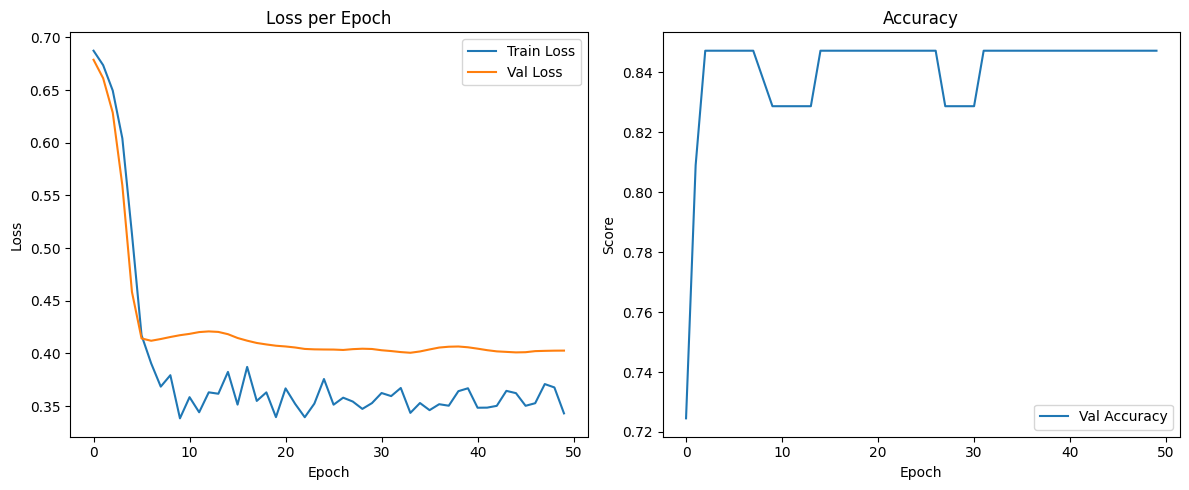

In [15]:
# ------------------ Plotting ------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()